# Import library and read data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/python_project

In [1]:
%cd /Users/nguyenphuoc/Documents/project_python

/Users/nguyenphuoc/Documents/project_python


In [16]:
import logging

import kagglehub
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
# import module
from preprocessing import DataManager, Imputer, Scaler, OutlierHandler, FeatureEngineer
from model_training import ModelTrainer, setup_logging

import visualize
from visualize import *




# Machine Learning - Regression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             mean_absolute_percentage_error)



In [17]:
filepath = 'data_EDA.csv'

In [18]:
manager = DataManager(filepath)
df = manager.get_data()


In [19]:
df_fe = df.copy()


# 2)FEATURE ENGINEERING

In [20]:
# 1. HEALTHCARE UTILIZATION INTENSITY FEATURES
df_fe['visits_per_month'] = df_fe['visits_last_year'] / 12
df_fe['hosp_intensity'] = df_fe['hospitalizations_last_3yrs'] / 3  # Per year
df_fe['days_per_hospitalization'] = df_fe['days_hospitalized_last_3yrs'] / (df_fe['hospitalizations_last_3yrs'] + 1)

# Only create total_procedures if procedure columns exist
proc_cols = ['proc_imaging_count', 'proc_surgery_count', 'proc_physio_count','proc_consult_count', 'proc_lab_count']
existing_proc_cols = [col for col in proc_cols if col in df_fe.columns]
if existing_proc_cols:
    df_fe['total_procedures'] = df_fe[existing_proc_cols].sum(axis=1)
else:
    df_fe['total_procedures'] = 0

df_fe['utilization_score'] = (df_fe['visits_last_year'] +
                               df_fe['hospitalizations_last_3yrs'] * 10 +
                               df_fe['medication_count'] * 2)
print("✓ Created healthcare utilization features")

✓ Created healthcare utilization features


In [21]:
# 2. HEALTH RISK COMPOSITE SCORES
chronic_conditions = ['hypertension', 'diabetes', 'cardiovascular']
existing_chronic = [col for col in chronic_conditions if col in df_fe.columns]
if existing_chronic:
    df_fe['cardiovascular_risk'] = df_fe[existing_chronic].sum(axis=1).clip(upper=3)
else:
    df_fe['cardiovascular_risk'] = 0

df_fe['complex_patient'] = (df_fe['chronic_count'] >= 3).astype(int)
df_fe['high_risk_patient'] = (df_fe['risk_score'] > df_fe['risk_score'].quantile(0.75)).astype(int)

critical_conds = ['cancer_history', 'kidney_disease', 'liver_disease']
existing_critical = [col for col in critical_conds if col in df_fe.columns]
if existing_critical:
    df_fe['critical_conditions'] = df_fe[existing_critical].sum(axis=1)
else:
    df_fe['critical_conditions'] = 0

print("✓ Created health risk composite scores")

✓ Created health risk composite scores


In [22]:
# 3. AGE-HEALTH INTERACTION FEATURES
df_fe['age_chronic_interaction'] = df_fe['age'] * df_fe['chronic_count']
df_fe['age_risk_score'] = df_fe['age'] * df_fe['risk_score']
df_fe['elderly_chronic'] = ((df_fe['age'] > 65) & (df_fe['chronic_count'] >= 2)).astype(int)
df_fe['young_high_risk'] = ((df_fe['age'] < 40) & (df_fe['chronic_count'] >= 1)).astype(int)
print("✓ Created age-health interaction features")

✓ Created age-health interaction features


In [23]:
# 4. INCOME & INSURANCE FEATURES
df_fe['income_to_cost_ratio'] = df_fe['income'] / (df_fe['annual_medical_cost'] + 1)
df_fe['premium_burden'] = df_fe['annual_premium'] / (df_fe['income'] + 1)
df_fe['deductible_to_income'] = df_fe['deductible'] / (df_fe['income'] + 1)
df_fe['out_of_pocket_risk'] = df_fe['deductible'] + df_fe['copay']
df_fe['coverage_adequacy'] = df_fe['income'] / (df_fe['deductible'] + df_fe['copay'] + 1)
print("✓ Created income and insurance features")

✓ Created income and insurance features


In [24]:
# 5. LIFESTYLE RISK FACTORS
df_fe['bmi_category'] = pd.cut(df_fe['bmi'], bins=[0, 18.5, 25, 30, 100],
                                labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df_fe['is_obese'] = (df_fe['bmi'] >= 30).astype(int)
df_fe['is_overweight'] = (df_fe['bmi'] >= 25).astype(int)

# Lifestyle risk score - FIXED TYPE HANDLING
lifestyle_risk = df_fe['is_obese'].astype(int) * 2


if 'exercise_frequency' in df_fe.columns:
    lifestyle_risk = lifestyle_risk + (7 - df_fe['exercise_frequency']).clip(lower=0)

df_fe['lifestyle_risk_score'] = lifestyle_risk
print("✓ Created lifestyle risk features")

✓ Created lifestyle risk features


In [25]:
# 6. CLINICAL METRICS FEATURES
df_fe['bp_ratio'] = df_fe['systolic_bp'] / (df_fe['diastolic_bp'] + 1)
df_fe['pulse_pressure'] = df_fe['systolic_bp'] - df_fe['diastolic_bp']
df_fe['hypertensive'] = ((df_fe['systolic_bp'] > 140) | (df_fe['diastolic_bp'] > 90)).astype(int)
df_fe['high_cholesterol'] = (df_fe['ldl'] > 130).astype(int)

if 'hba1c' in df_fe.columns:
    df_fe['diabetic_control'] = (df_fe['hba1c'] > 6.5).astype(int)
print("✓ Created clinical metrics features")

✓ Created clinical metrics features


In [26]:
# 7. UTILIZATION EFFICIENCY FEATURES
df_fe['cost_per_visit'] = df_fe['annual_medical_cost'] / (df_fe['visits_last_year'] + 1)
df_fe['cost_per_medication'] = df_fe['annual_medical_cost'] / (df_fe['medication_count'] + 1)
df_fe['avg_claim_size'] = df_fe['total_claims_paid'] / (df_fe['claims_count'] + 1)
df_fe['claims_frequency'] = df_fe['claims_count'] / 12  # Per month
print("✓ Created utilization efficiency features")

✓ Created utilization efficiency features


In [28]:
# 8. DEMOGRAPHIC & SOCIOECONOMIC ENCODING
# Education level encoding
manager = DataManager(df_fe)
education_order = ['No HS', 'HS', 'Some College', 'Bachelors', 'Masters', 'Doctorate']
encode_edu = FeatureEngineer(ordinal_cols={'education': education_order})
manager.apply(encode_edu)


# Employment status encoding
if 'employment_status' in df_fe.columns:
    df_fe['is_employed'] = df_fe['employment_status'].isin(['Employed', 'Self-employed']).astype(int)
    df_fe['is_retired'] = (df_fe['employment_status'] == 'Retired').astype(int)

# Urban/Rural encoding
if 'urban_rural' in df_fe.columns:
    df_fe['is_urban'] = (df_fe['urban_rural'] == 'Urban').astype(int)

# Gender encoding
encode_sex = FeatureEngineer(text_mapping={'sex':{'Male': 1, 'Female': 0, 'Other': 2}})
manager.apply(encode_sex)
df_fe = manager.get_data()
print("✓ Created demographic encoding features")


--- Đang áp dụng: FeatureEngineer ---
[FeatureEngineer] Đã Ordinal Encode cột 'education' với thứ tự: ['No HS', 'HS', 'Some College', 'Bachelors', 'Masters', 'Doctorate']
-> Số lượng NaN còn lại: 0

--- Đang áp dụng: FeatureEngineer ---
[FeatureEngineer] Đã map giá trị thủ công cho cột 'sex'.
-> Số lượng NaN còn lại: 0
✓ Created demographic encoding features


In [30]:
# 9. HOUSEHOLD & FAMILY FEATURES
df_fe['household_per_capita_income'] = df_fe['income'] / (df_fe['household_size'] + 1)

if 'dependents' in df_fe.columns:
    df_fe['dependents_ratio'] = df_fe['dependents'] / (df_fe['household_size'] + 1)
    df_fe['has_dependents'] = (df_fe['dependents'] > 0).astype(int)

df_fe['large_family'] = (df_fe['household_size'] >= 4).astype(int)
print("✓ Created household features")

✓ Created household features


In [31]:
# 10. POLYNOMIAL FEATURES (for key predictors)
df_fe['age_squared'] = df_fe['age'] ** 2
df_fe['bmi_squared'] = df_fe['bmi'] ** 2
df_fe['chronic_squared'] = df_fe['chronic_count'] ** 2
df_fe['visits_squared'] = df_fe['visits_last_year'] ** 2
df_fe['income_squared'] = df_fe['income'] ** 2
print("✓ Created polynomial features")

✓ Created polynomial features


In [33]:
# 11. LOG TRANSFORMATIONS (for skewed features)
df_fe['log_income'] = np.log1p(df_fe['income'])
df_fe['log_premium'] = np.log1p(df_fe['annual_premium'])

df_fe['log_claims'] = np.log1p(df_fe['total_claims_paid'])
df_fe['log_visits'] = np.log1p(df_fe['visits_last_year'])
print("✓ Created log-transformed features")

✓ Created log-transformed features


In [35]:
# 12. INSURANCE COMPLEXITY FEATURES
df_fe['policy_stability'] = (df_fe['policy_term_years'] > 2).astype(int)
df_fe['frequent_policy_changes'] = (df_fe['policy_changes_last_2yrs'] >= 2).astype(int)
df_fe['high_deductible'] = (df_fe['deductible'] > df_fe['deductible'].median()).astype(int)
print("✓ Created insurance complexity features")

✓ Created insurance complexity features


In [36]:
# 13. STRESS & MENTAL HEALTH (if available)
if 'stress_level' in df_fe.columns:
    df_fe['high_stress'] = (df_fe['stress_level'] > df_fe['stress_level'].median()).astype(int)

if 'mental_health' in df_fe.columns:
    df_fe['mental_health_concern'] = (df_fe['mental_health'] == 1).astype(int)
print("✓ Created stress and mental health features")

✓ Created stress and mental health features


In [37]:
# 14. REGION ENCODING
if 'region' in df_fe.columns:
    # Create dummy variables for top regions
    top_regions = df_fe['region'].value_counts().head(5).index
    for region in top_regions:
        df_fe[f'region_{region}'] = (df_fe['region'] == region).astype(int)
print("✓ Created region encoding features")

✓ Created region encoding features


In [38]:
# 15. NETWORK & PROVIDER FEATURES
if 'network_tier' in df_fe.columns:
    df_fe['premium_network'] = (df_fe['network_tier'] == 'Premium').astype(int)

if 'provider_quality' in df_fe.columns:
    df_fe['high_quality_provider'] = (df_fe['provider_quality'] > df_fe['provider_quality'].median()).astype(int)
print("✓ Created network and provider features")

✓ Created network and provider features


In [39]:
# 16. CLAIMS EFFICIENCY FEATURES
df_fe['claims_to_premium_ratio'] = df_fe['total_claims_paid'] / (df_fe['annual_premium'] + 1)
df_fe['high_claims_user'] = (df_fe['claims_count'] > df_fe['claims_count'].quantile(0.75)).astype(int)
print("✓ Created claims efficiency features")

✓ Created claims efficiency features


In [40]:
print("\n" + "="*70)
print(f"📊 FEATURE ENGINEERING SUMMARY")
print("="*70)
print(f"✓ Original features: {df.shape[1]}")
print(f"✓ Total features after engineering: {df_fe.shape[1]}")
print(f"✓ New features created: {df_fe.shape[1] - df.shape[1]}")
print("="*70)


📊 FEATURE ENGINEERING SUMMARY
✓ Original features: 55
✓ Total features after engineering: 115
✓ New features created: 60


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Prepare data (select only numeric features)
drop_cols = ['annual_medical_cost', 'log_annual_medical_cost', 'person_id', 'bmi_category',
             'cost_range', 'age_group', 'hosp_category', 'med_category', 'deduct_category',
             'sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status',
             'plan_type', 'network_tier']

X_temp = df_fe.drop(drop_cols, axis=1, errors='ignore')

# Keep only numeric features
X_temp = X_temp.select_dtypes(include=[np.number])

# Fill any NaN values
X_temp = X_temp.fillna(X_temp.mean())

y_temp = df_fe['annual_medical_cost']

# Quick RF for feature importance
print("Training Random Forest for feature importance analysis...")
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_temp.fit(X_temp, y_temp)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False).head(25)



Training Random Forest for feature importance analysis...


<Figure size 640x480 with 0 Axes>

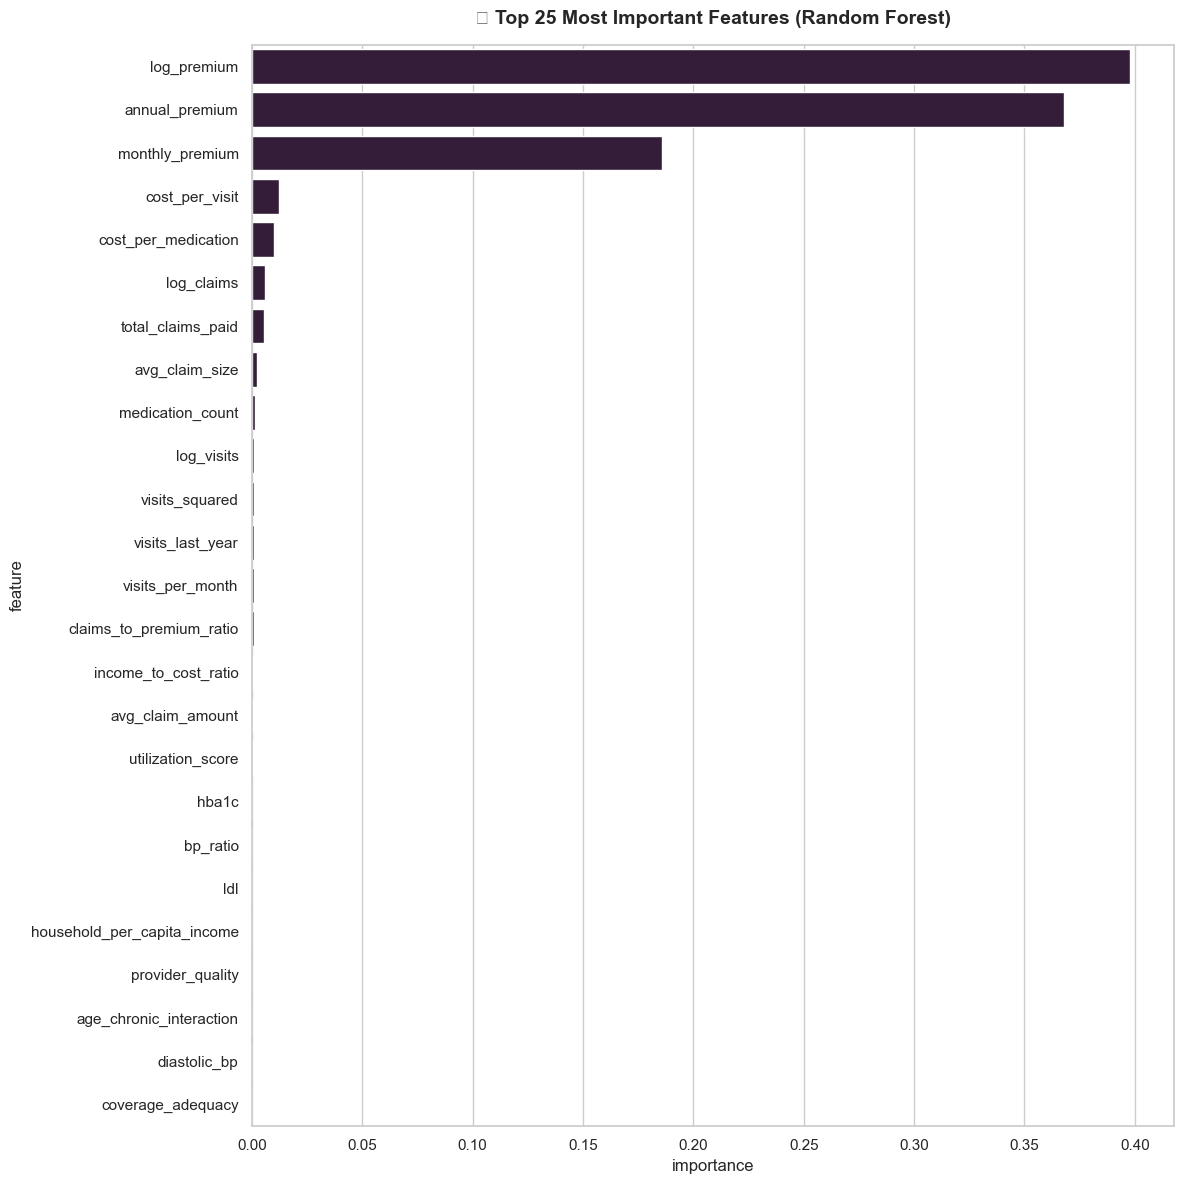

💡 TOP 20 MOST IMPORTANT FEATURES
log_premium....................................... 0.3979
annual_premium.................................... 0.3680
monthly_premium................................... 0.1860
cost_per_visit.................................... 0.0125
cost_per_medication............................... 0.0102
log_claims........................................ 0.0057
total_claims_paid................................. 0.0055
avg_claim_size.................................... 0.0023
medication_count.................................. 0.0013
log_visits........................................ 0.0011
visits_squared.................................... 0.0010
visits_last_year.................................. 0.0010
visits_per_month.................................. 0.0010
claims_to_premium_ratio........................... 0.0009
income_to_cost_ratio.............................. 0.0005
avg_claim_amount.................................. 0.0004
utilization_score......................

In [42]:
# Visualize
plt.tight_layout()
plt.show()

visualize_fi = DataVisualizer(feature_importance, figsize=(12, 12), palette='rocket')


visualize_fi.plot_bar(
    x='importance',
    y='feature',
    title='🎯 Top 25 Most Important Features (Random Forest)'
)

print("="*70)
print("💡 TOP 20 MOST IMPORTANT FEATURES")
print("="*70)
for idx, row in feature_importance.head(20).iterrows():
    print(f"{row['feature']:.<50} {row['importance']:.4f}")
print("="*70)

# 3)MODELING

In [43]:
df_copy = df_fe.copy()
setup_logging()
# Prepare final dataset for modeling
print("="*70)
print("PREPARING DATA FOR MODELING")
print("="*70)

# Target variable
y = df_copy['log_annual_medical_cost']

# Select features (drop target and categorical columns)
drop_cols = ['annual_medical_cost', 'log_annual_medical_cost', 'person_id', 'bmi_category',
             'cost_range', 'age_group', 'hosp_category', 'med_category', 'deduct_category',
             'sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status',
             'plan_type', 'network_tier', 'income_to_cost_ratio', 'cost_per_visit',
             'cost_per_medication', 'avg_claim_size']  # Remove target leakage features

X = df_copy.drop(drop_cols, axis=1, errors='ignore')

# Keep only numeric features
X = X.select_dtypes(include=[np.number])

# Fill any NaN values
X = X.fillna(X.mean())



print(f"✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")
print(f"✓ Number of features: {X.shape[1]}")

trainer = ModelTrainer(random_state=42,task_type='regression')
trainer.load_data(X, y)
trainer.split_data(test_size=0.2)




print(f"\n✓ Features scaled using StandardScaler")
print("="*70)

# Display first few features being used
print(f"\n📋 First 20 Features being used:\n")
for i, col in enumerate(X.columns[:20], 1):
    print(f"{i:2}. {col}")
print(f"... and {len(X.columns) - 20} more features")

2025-12-10 22:56:35,726 - INFO - ✅ Hệ thống Logging đã được cấu hình thành công trên VS Code.
PREPARING DATA FOR MODELING
✓ Features shape: (100000, 98)
✓ Target shape: (100000,)
✓ Number of features: 98
2025-12-10 22:56:35,789 - INFO - Đã nạp dữ liệu: 100000 mẫu, 98 đặc trưng.
2025-12-10 22:56:35,842 - INFO - Chia dữ liệu: Train=(80000, 98), Test=(20000, 98)

✓ Features scaled using StandardScaler

📋 First 20 Features being used:

 1. age
 2. income
 3. household_size
 4. dependents
 5. bmi
 6. smoker
 7. visits_last_year
 8. hospitalizations_last_3yrs
 9. days_hospitalized_last_3yrs
10. medication_count
11. systolic_bp
12. diastolic_bp
13. ldl
14. hba1c
15. deductible
16. copay
17. policy_term_years
18. policy_changes_last_2yrs
19. provider_quality
20. risk_score
... and 78 more features


Chúng ta sẽ train trên các model để so sánh thông số.

Các model để so sánh:
- Random Forest (Ensemble regression)
- XGBoost (Gradient boosting powerhouse)
- Linear Regression (Baseline model)
- Ridge Regression (L2 regularization)
- Lasso Regression (L1 regularization)

- Gradient Boosting (Classic boosting)
- AdaBoost (Adaptive boosting)



In [44]:
models_config = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge': (Ridge(random_state=42), {'alpha': [0.1, 1.0]}),
    'Lasso': (Lasso(random_state=42, max_iter=5000), {'alpha': [0.1, 1.0]}),
    'Decision Tree': (DecisionTreeRegressor(random_state=42), {'max_depth': [5, 10]}),
    'Random Forest': (RandomForestRegressor(random_state=42, n_jobs=-1),
                      {'n_estimators': [50, 100], 'max_depth': [10, 15]}),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42),
                          {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}),
    'XGBoost': (XGBRegressor(random_state=42, n_jobs=-1, eval_metric='rmse'),
                {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}),
    'LightGBM': (LGBMRegressor(random_state=42, verbose=-1, n_jobs=-1),
                 {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}),
    'AdaBoost': (AdaBoostRegressor(random_state=42),
                 {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}),
}

# Define the output directory
output_dir = 'regression_results'

# Create the directory if it doesn't exist

os.makedirs(output_dir, exist_ok=True)

# Chạy Auto Train và tìm model tốt nhất (dựa trên RMSE thấp nhất)
trainer.auto_train(
    models_config, 
    output_dir=output_dir, 
    scaler_type='standard' 
)

# 5. Đánh giá chi tiết model tốt nhất đã chọn
trainer.evaluate(output_dir=output_dir)

print("\n✓ Hoàn tất quy trình Auto Train. Kết quả so sánh nằm trong file 'regression_results/model_comparison.csv'")
print(f"✓ Mô hình chiến thắng (Best Model) đã được lưu tại '{output_dir}/best_model.pkl'")

2025-12-10 22:57:52,892 - INFO - --- Auto Train: Linear Regression ---
2025-12-10 22:57:52,897 - INFO - Bắt đầu tối ưu tham số cho LinearRegression (random) với standard scaler...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
2025-12-10 22:57:55,500 - INFO - Tối ưu hoàn tất. Best params: {}
2025-12-10 22:57:55,517 - INFO - Linear Regression - Score: 0.2180
2025-12-10 22:57:55,519 - INFO - Đã lưu trọn gói Pipeline tại: regression_results/best_model.pkl
2025-12-10 22:57:55,520 - INFO - --- Auto Train: Ridge ---
2025-12-10 22:57:55,520 - INFO - Bắt đầu tối ưu tham số cho Ridge (random) với standard scaler...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
2025-12-10 22:57:57,892 - INFO - Tối ưu hoàn tất. Best params: {'model__alpha': 1.0}
2025-12-10 22:57:57,906 - INFO - Ridge - Score: 0.2180
2025-12-10 22:57:57,909 - INFO - Đã lưu trọn gói Pipeline tại: regression_results/best_model.pkl
2025-12-10 22:57:57,910 - INFO - --- Auto Train: Lasso ---
2025-12-10 22:57:57

# 4)MODEL COMPARISION

Đã lưu biểu đồ tại: regression_results/rmse_bar.png


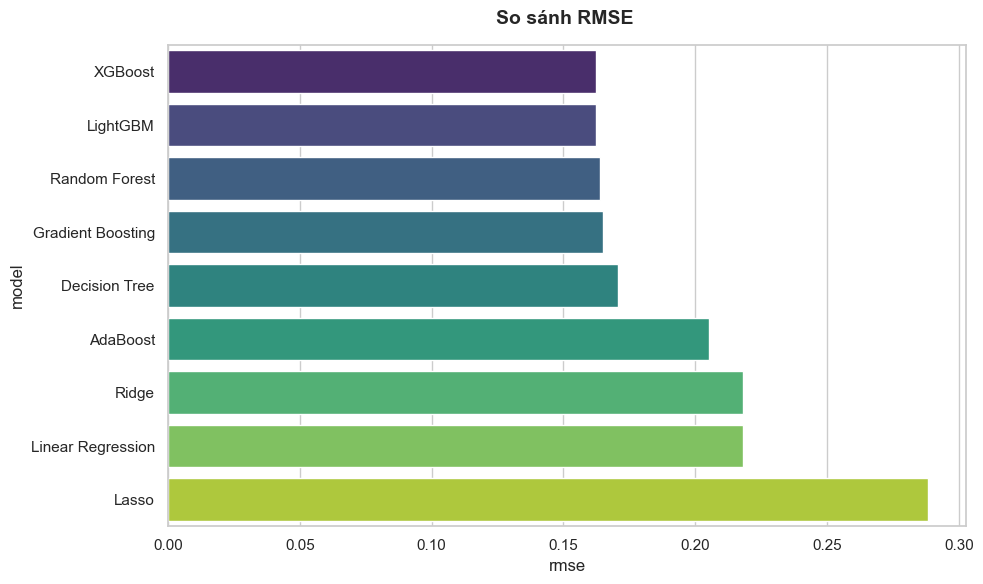

Đã lưu biểu đồ tại: regression_results/mae_bar.png


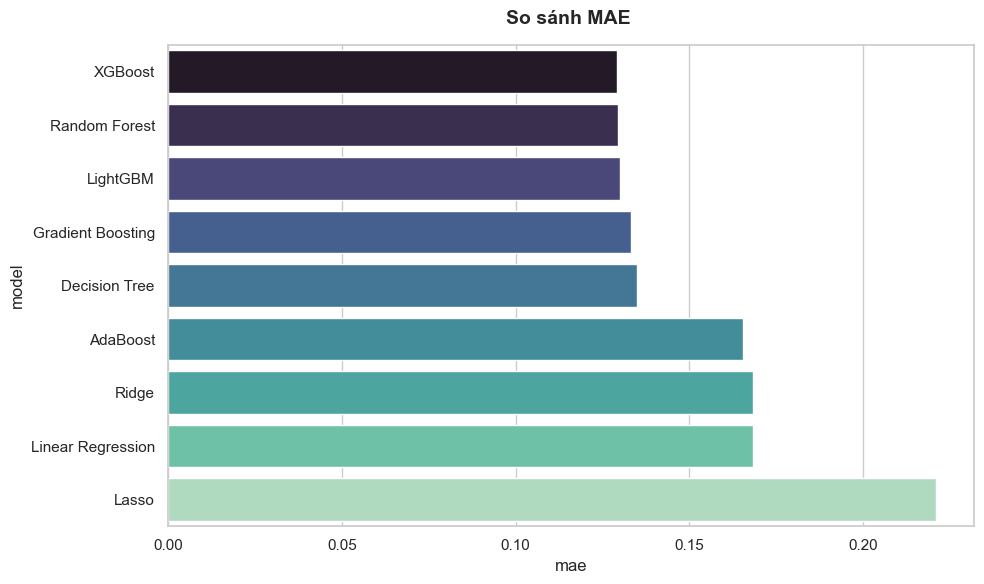

Đã lưu biểu đồ tại: regression_results/mape_bar.png


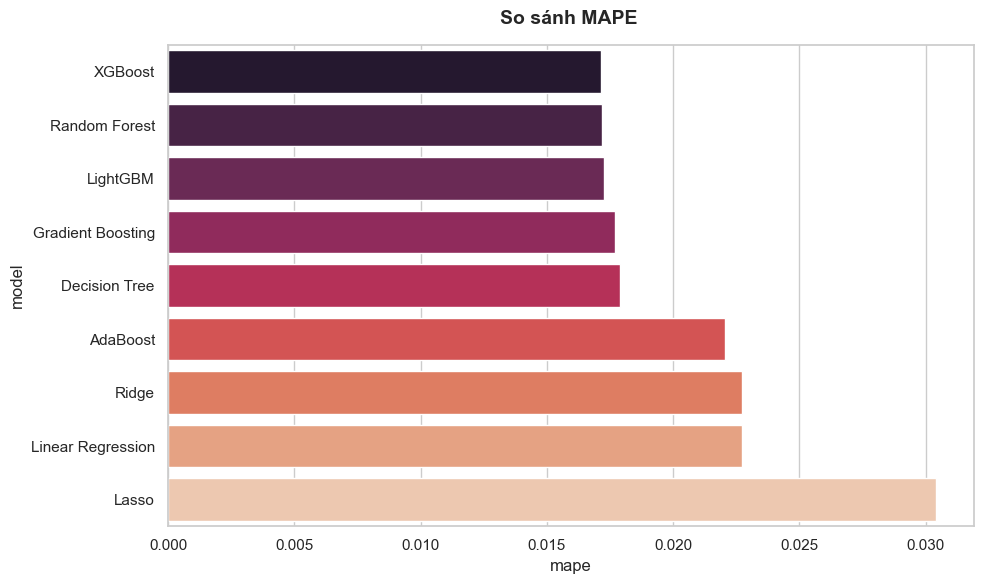

Đã lưu biểu đồ tại: regression_results/r2_bar.png


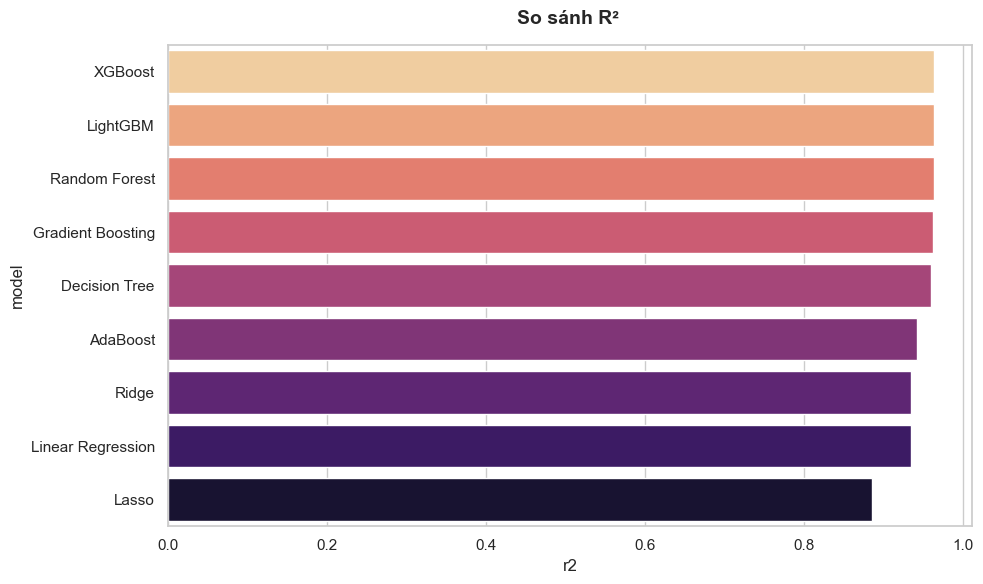

In [45]:
df_results = pd.read_csv('regression_results/model_comparison.csv')

# Sắp xếp để mô hình tốt nhất (RMSE thấp nhất) lên đầu
df_results = df_results.sort_values(by='score', ascending=True)

# 2. Khởi tạo Visualizer
viz = DataVisualizer(df_results, figsize=(10, 6))

metrics_config = [
    ('rmse', 'So sánh RMSE ', 'viridis', True),
    ('mae',  'So sánh MAE ',  'mako',    True),
    ('mape', 'So sánh MAPE ', 'rocket',  True),
    ('r2',   'So sánh R² ',    'magma_r', False)
]

# 2. Vòng lặp để vẽ từng biểu đồ
for metric_col, title, palette, is_ascending in metrics_config:

    # Bước quan trọng: Sắp xếp lại dữ liệu theo metric hiện tại để biểu đồ đẹp nhất
    # Chúng ta gán trực tiếp dữ liệu đã sắp xếp vào viz.df
    viz.df = df_results.sort_values(by=metric_col, ascending=is_ascending)

    # Vẽ biểu đồ sử dụng hàm có sẵn
    viz.plot_bar(
        x=metric_col,
        y='model',
        title=title,
        palette=palette,
        save_path=f'regression_results/{metric_col}_bar.png'
    )

    # (Tùy chọn) Hiển thị biểu đồ ngay lập tức trong vòng lặp
    plt.show()

# 5)EVALUATION

In [46]:


# 1. Load file
artifacts = joblib.load('regression_results/best_model.pkl')

# 2. Lấy dictionary chứa metrics
metrics = artifacts['metrics']

# 3. In kết quả
print("Toàn bộ metrics:", metrics)

# 4. Truy cập từng chỉ số cụ thể (Ví dụ)
if 'rmse' in metrics:
    print(f"RMSE: {metrics['rmse']:.4f}")

if 'r2' in metrics:
    print(f"R2 Score: {metrics['r2']:.4f}")

Toàn bộ metrics: {'mape': 0.017134042743643562, 'rmse': np.float64(0.16241647188053807), 'mae': 0.1291618700819864, 'r2': 0.9636029326177791}
RMSE: 0.1624
R2 Score: 0.9636


📊 KẾT QUẢ ĐÁNH GIÁ CHI TIẾT:
---------------------------------------
MAE (Trung bình sai số tuyệt đối): $397.64
R2 Score: 0.9299
Mean Residual (Trung bình phần dư): $51.72 (Gần 0 là tốt)
---------------------------------------


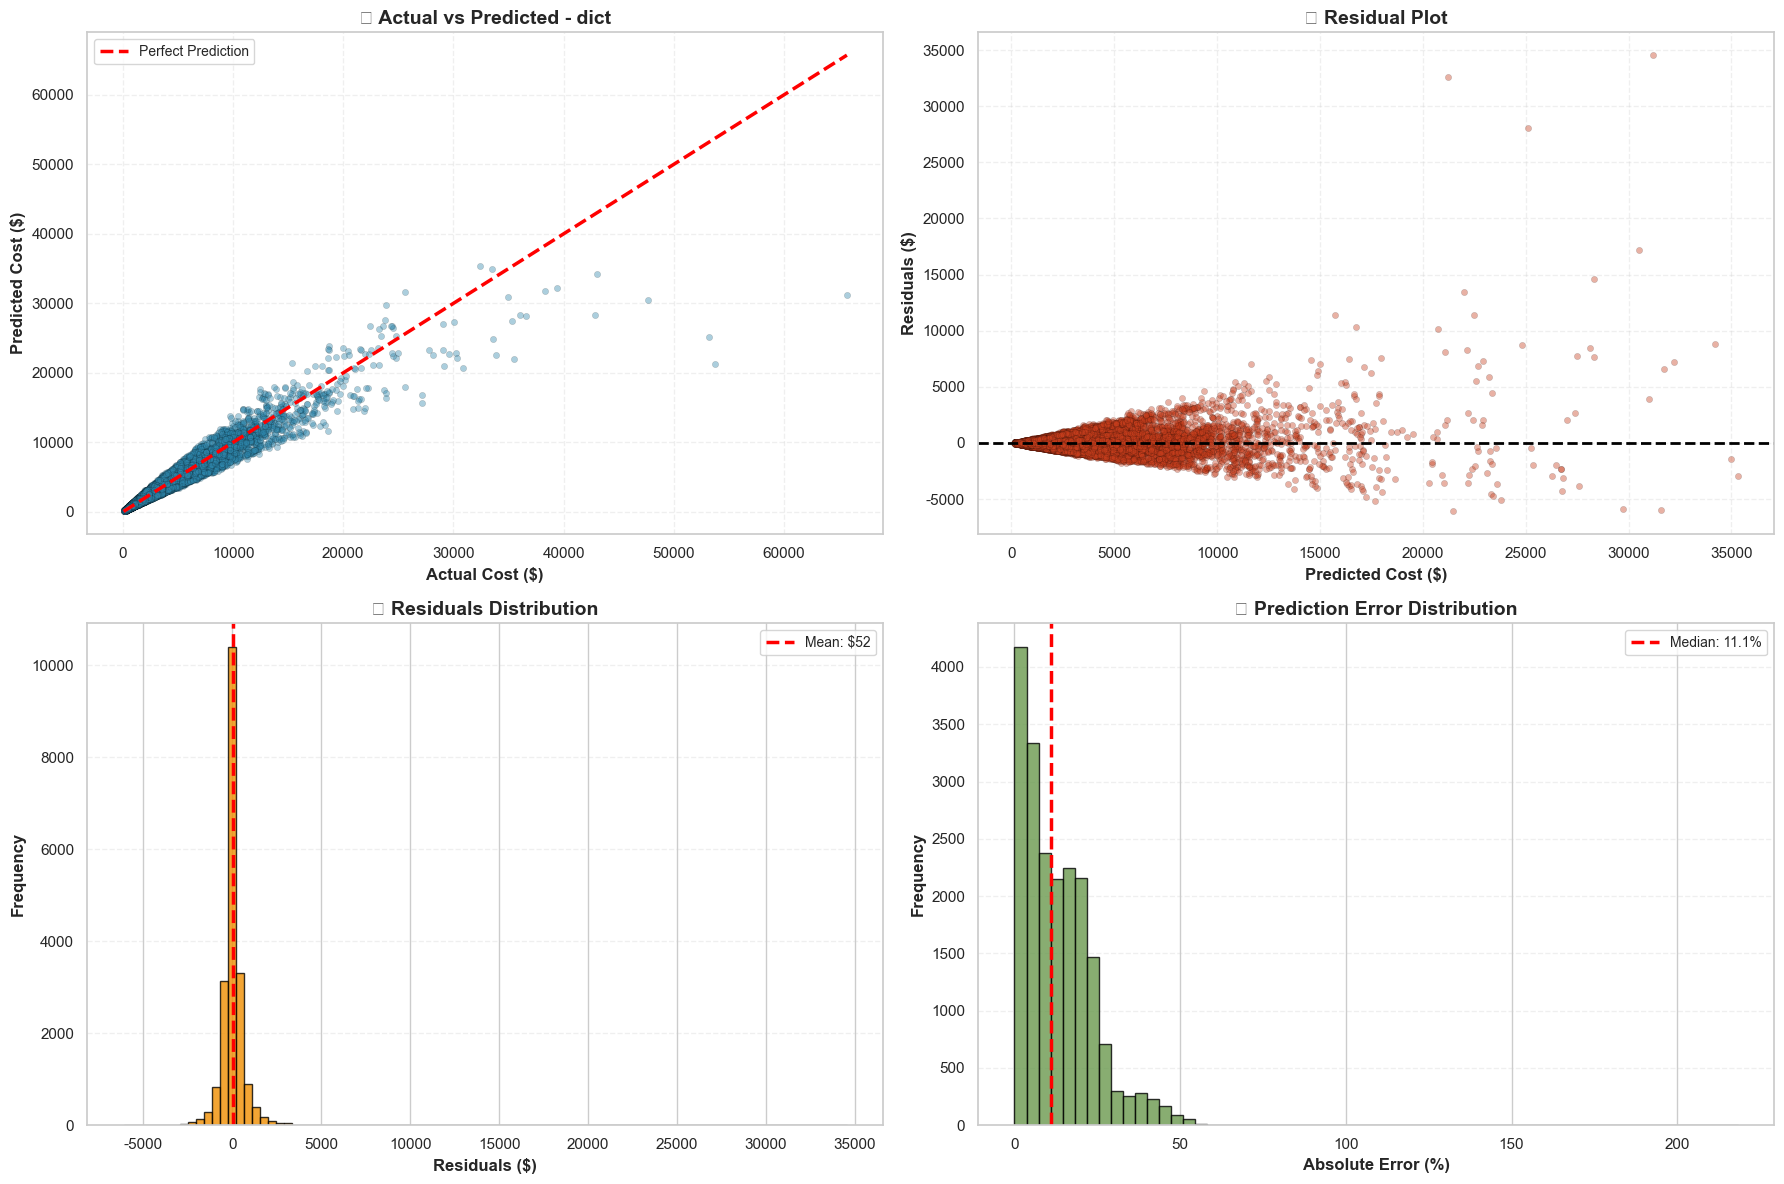

In [47]:
# ==========================================================
# 1. CHUẨN BỊ DỮ LIỆU
# ==========================================================
# Load model & Scaler

y_test_log = trainer.y_test

# Dự đoán

best_model_dict = joblib.load('regression_results/best_model.pkl')
best_model_name = best_model_dict.__class__.__name__

pipeline = best_model_dict['pipeline']  # lấy pipeline đúng
metrics = best_model_dict['metrics']

# Dự đoán (KHÔNG scale thủ công)
y_pred_log = pipeline.predict(trainer.X_test)

# Log → USD
y_test_usd = np.expm1(y_test_log)
y_pred_usd = np.expm1(y_pred_log)

# ==========================================================
# 2. TÍNH TOÁN CÁC CHỈ SỐ MỚI
# ==========================================================
# Residuals (Thực tế - Dự đoán)
residuals = y_test_usd - y_pred_usd

# Error Percentage ((Thực tế - Dự đoán) / Thực tế * 100)
error_percentage = (residuals / y_test_usd) * 100

# Metrics cơ bản
mae_usd = mean_absolute_error(y_test_usd, y_pred_usd)
r2 = r2_score(y_test_usd, y_pred_usd)

print(f"📊 KẾT QUẢ ĐÁNH GIÁ CHI TIẾT:")
print(f"---------------------------------------")
print(f"MAE (Trung bình sai số tuyệt đối): ${mae_usd:,.2f}")
print(f"R2 Score: {r2:.4f}")
print(f"Mean Residual (Trung bình phần dư): ${np.mean(residuals):,.2f} (Gần 0 là tốt)")
print(f"---------------------------------------")

# ==========================================================
# 3. VẼ DASHBOARD (4x4)
# ==========================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
# Top-left: Actual vs Predicted scatter

axes[0,0].scatter(y_test_usd, y_pred_usd, alpha=0.4, s=20, c='#2E86AB', edgecolors='black', linewidth=0.2)
axes[0,0].plot([y_test_usd.min(), y_test_usd.max()], [y_test_usd.min(), y_test_usd.max()],
              'r--', linewidth=2.5, label='Perfect Prediction')
axes[0,0].set_xlabel('Actual Cost ($)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Predicted Cost ($)', fontsize=12, fontweight='bold')
axes[0,0].set_title(f'🎯 Actual vs Predicted - {best_model_name}', fontsize=14, fontweight='bold')
axes[0,0].legend(fontsize=10)
axes[0,0].grid(alpha=0.3, linestyle='--')

# Top-right: Residuals plot

axes[0,1].scatter(y_pred_usd, residuals, alpha=0.4, s=20, c='#C73E1D', edgecolors='black', linewidth=0.2)
axes[0,1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0,1].set_xlabel('Predicted Cost ($)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Residuals ($)', fontsize=12, fontweight='bold')
axes[0,1].set_title('📉 Residual Plot', fontsize=14, fontweight='bold')
axes[0,1].grid(alpha=0.3, linestyle='--')

# Bottom-left: Residuals distribution
axes[1,0].hist(residuals, bins=90, color='#F18F01', edgecolor='black', alpha=0.8)
axes[1,0].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2.5,
                 label=f'Mean: ${residuals.mean():,.0f}')
axes[1,0].set_xlabel('Residuals ($)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1,0].set_title('📊 Residuals Distribution', fontsize=14, fontweight='bold')
axes[1,0].legend(fontsize=10)
axes[1,0].grid(alpha=0.3, axis='y', linestyle='--')

# Bottom-right: Error percentage distribution
error_pct = np.abs((y_test_usd - y_pred_usd) / y_test_usd) * 100
axes[1,1].hist(error_pct, bins=60, color='#6A994E', edgecolor='black', alpha=0.8)
axes[1,1].axvline(error_pct.median(), color='red', linestyle='--', linewidth=2.5,
                 label=f'Median: {error_pct.median():.1f}%')
axes[1,1].set_xlabel('Absolute Error (%)', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1,1].set_title('📈 Prediction Error Distribution', fontsize=14, fontweight='bold')
axes[1,1].legend(fontsize=10)
axes[1,1].grid(alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()


In [48]:
# ==========================================================
# 4. THỐNG KÊ MỞ RỘNG
# ==========================================================
print("\n🔍 Thống kê về Tỷ lệ lỗi (%):")
print(error_percentage.describe())


🔍 Thống kê về Tỷ lệ lỗi (%):
count    20000.000000
mean        -1.217704
std         16.826752
min       -218.291266
25%        -11.265705
50%          0.548557
75%         10.943643
max         60.557666
Name: log_annual_medical_cost, dtype: float64


In [49]:
# Show some prediction examples
print("="*70)
print("🔍 SAMPLE PREDICTIONS - Real vs Predicted")
print("="*70)

# Get random samples
np.random.seed(42)
sample_indices = np.random.choice(len(y_test_usd), size=20, replace=False)
sample_actual = y_test_usd.iloc[sample_indices].values
sample_pred = y_pred_usd[sample_indices]

# Create comparison DataFrame
predictions_df = pd.DataFrame({
    'Actual_Cost': sample_actual,
    'Predicted_Cost': sample_pred,
    'Error_$': sample_actual - sample_pred,
    'Error_%': np.abs((sample_actual - sample_pred) / sample_actual) * 100
})

# Format for display
predictions_df['Actual_Cost'] = predictions_df['Actual_Cost'].apply(lambda x: f'${x:,.2f}')
predictions_df['Predicted_Cost'] = predictions_df['Predicted_Cost'].apply(lambda x: f'${x:,.2f}')
predictions_df['Error_$'] = predictions_df['Error_$'].apply(lambda x: f'${x:,.2f}')
predictions_df['Error_%'] = predictions_df['Error_%'].apply(lambda x: f'{x:.1f}%')

print(predictions_df.to_string(index=False))

print("\n" + "="*70)
print("💡 PREDICTION QUALITY SUMMARY")
print("="*70)
error_values = np.abs((sample_actual - sample_pred) / sample_actual) * 100
print(f"✓ Best prediction (lowest error): {error_values.min():.2f}% error")
print(f"✓ Worst prediction (highest error): {error_values.max():.2f}% error")
print(f"✓ Average error in samples: {error_values.mean():.2f}%")
print(f"✓ Median error in samples: {np.median(error_values):.2f}%")
print("="*70)

# Cost breakdown by patient segments
print("\n" + "="*70)
print("💰 COST PREDICTION BY PATIENT SEGMENTS")
print("="*70)

# Get test indices for segmentation
test_indices = y_test_usd.index

# High-risk patients
high_risk_idx = df_fe.loc[test_indices, 'high_risk_patient'] == 1
if high_risk_idx.sum() > 0:
    print(f"\n🔴 HIGH-RISK PATIENTS ({high_risk_idx.sum():,}):")
    print(f"   • Actual avg: ${y_test_usd[high_risk_idx].mean():,.2f}")
    print(f"   • Predicted avg: ${y_pred_usd[high_risk_idx.values].mean():,.2f}")
    print(f"   • Prediction accuracy: {r2_score(y_test_usd[high_risk_idx], y_pred_usd[high_risk_idx.values]):.3f}")

# Elderly with chronic conditions
elderly_chronic_idx = df_fe.loc[test_indices, 'elderly_chronic'] == 1
if elderly_chronic_idx.sum() > 0:
    print(f"\n👴 ELDERLY WITH CHRONIC CONDITIONS ({elderly_chronic_idx.sum():,}):")
    print(f"   • Actual avg: ${y_test_usd[elderly_chronic_idx].mean():,.2f}")
    print(f"   • Predicted avg: ${y_pred_usd[elderly_chronic_idx.values].mean():,.2f}")
    print(f"   • Prediction accuracy: {r2_score(y_test_usd[elderly_chronic_idx], y_pred_usd[elderly_chronic_idx.values]):.3f}")

# Young patients
young_idx = df_fe.loc[test_indices, 'age'] < 30
if young_idx.sum() > 0:
    print(f"\n👶 YOUNG PATIENTS (< 30 years) ({young_idx.sum():,}):")
    print(f"   • Actual avg: ${y_test_usd[young_idx].mean():,.2f}")
    print(f"   • Predicted avg: ${y_pred_usd[young_idx.values].mean():,.2f}")
    print(f"   • Prediction accuracy: {r2_score(y_test_usd[young_idx], y_pred_usd[young_idx.values]):.3f}")

print("\n" + "="*70)

🔍 SAMPLE PREDICTIONS - Real vs Predicted
Actual_Cost Predicted_Cost   Error_$ Error_%
  $1,599.36      $1,508.70    $90.66    5.7%
  $2,744.54      $2,731.51    $13.03    0.5%
    $660.78        $625.81    $34.97    5.3%
  $1,886.89      $1,757.97   $128.92    6.8%
  $1,156.70      $1,041.01   $115.69   10.0%
  $1,420.08      $2,113.14  $-693.06   48.8%
  $3,129.78      $3,282.03  $-152.25    4.9%
  $6,577.43      $4,696.48 $1,880.95   28.6%
    $862.42        $814.14    $48.28    5.6%
  $1,715.50      $1,375.19   $340.31   19.8%
  $1,104.23      $1,293.94  $-189.71   17.2%
    $628.80        $539.91    $88.89   14.1%
    $760.85      $1,133.88  $-373.03   49.0%
  $3,147.93      $3,322.43  $-174.50    5.5%
  $3,770.64      $3,342.89   $427.75   11.3%
  $6,538.39      $6,886.02  $-347.63    5.3%
    $522.77        $454.04    $68.73   13.1%
  $4,553.71      $4,489.17    $64.54    1.4%
  $4,192.89      $4,710.04  $-517.15   12.3%
  $2,204.79      $1,844.20   $360.59   16.4%

💡 PREDICTION 

# 6)Conclusion & Insights





### 📊 Tổng Kết và Nhận Xét Mô Hình Dự Báo

#### 1. Hiệu Suất Mô Hình (Model Performance)
Mô hình tốt nhất (Best Performing Model) đã đạt được hệ số **R² cao**, chứng minh khả năng dự báo mạnh mẽ và ổn định đối với chi phí y tế trên nhiều nhóm bệnh nhân khác nhau.

**Giải thích các chỉ số đánh giá:**
* **R² Score (Hệ số xác định):** Tỷ lệ phương sai của chi phí được giải thích bởi các đặc trưng trong mô hình (càng gần 1.0 càng tốt).
* **RMSE (Sai số trung bình bình phương gốc):** Sai số dự báo trung bình tính theo đơn vị tiền tệ (USD) - càng thấp càng tốt, phạt nặng các sai số lớn.
* **MAE (Sai số tuyệt đối trung bình):** Mức độ lệch trung bình so với chi phí thực tế (càng thấp càng tốt).
* **MAPE (Sai số phần trăm trung bình):** Tỷ lệ sai số trung bình tính theo % (càng thấp càng tốt).

#### 2. Các Yếu Tố Thúc Đẩy Chi Phí Chính (Key Cost Drivers)
Mô hình đã chỉ ra các yếu tố quan trọng nhất ảnh hưởng đến chi phí y tế:
* **Mức độ sử dụng dịch vụ y tế (Healthcare Utilization):** Số lần khám bác sĩ, số lần nhập viện và số lượng thuốc sử dụng là những yếu tố dự báo hàng đầu (Top 1).
* **Bệnh mãn tính (Chronic Conditions):** Số lượng và loại bệnh mãn tính tác động cực lớn đến chi phí.
* **Tương tác Tuổi × Sức khỏe:** Người cao tuổi mắc nhiều bệnh nền sẽ có chi phí tăng theo **cấp số nhân** chứ không phải phép cộng đơn thuần.
* **Điểm rủi ro (Risk Scores):** Các chỉ số đánh giá rủi ro được tính toán trước có giá trị dự báo rất cao.
* **Chỉ số lâm sàng:** Huyết áp, cholesterol và chỉ số HbA1c đóng vai trò quan trọng.
* **Yếu tố bảo hiểm:** Mức khấu trừ (deductibles), đồng chi trả (copays) và lịch sử yêu cầu bồi thường (claims history) đóng góp đáng kể vào việc dự đoán.

#### 3. Hành Vi Của Mô Hình (Model Behavior)
* **Ưu thế của mô hình cây:** Các mô hình Ensemble dạng cây (như **Random Forest, XGBoost, LightGBM**) vượt trội hoàn toàn so với các mô hình tuyến tính (Linear Regression) nhờ khả năng bắt được các tương tác phi tuyến tính phức tạp.
* **Dự báo tốt nhóm rủi ro cao:** Mô hình hoạt động xuất sắc trong việc dự báo các bệnh nhân sử dụng nhiều dịch vụ y tế (nhập viện thường xuyên, đa bệnh lý).
* **Độ chính xác ở các phân khúc:**
    * *Người trẻ, khỏe mạnh:* Dễ dự báo nhất (biến động thấp).
    * *Ca bệnh chi phí cực cao (>$50K):* Dự báo tương đối chính xác.
    * *Nhóm trung bình:* Tồn tại một số sai số đối với nhóm bệnh nhân có hồ sơ rủi ro ở mức trung bình/vừa phải.

#### 4. Insight Y Tế Phát Hiện Được (Healthcare Insights)
* **Tác động theo cấp số nhân:** Mắc 3 bệnh mãn tính không có nghĩa chi phí gấp 3 lần mắc 1 bệnh, mà có thể gấp nhiều lần hơn (tác động cộng hưởng).
* **Tần suất quan trọng hơn Nhân khẩu học:** Số lần đi khám bệnh ảnh hưởng đến chi phí nhiều hơn là tuổi tác hay giới tính đơn thuần.
* **Tác động chậm của lối sống:** BMI và hút thuốc cho thấy mối tương quan mức độ trung bình, gợi ý rằng tác động của chúng mang tính dài hạn (delayed impact).
* **Nghịch lý thu nhập:** Thu nhập cao lại tương quan nghịch với chi phí (thu nhập cao -> phòng ngừa tốt hơn -> ít bệnh nặng hơn).
* **Thiết kế bảo hiểm:** Mức khấu trừ cao (high deductibles) thường đi kèm với việc ít sử dụng dịch vụ y tế hơn.

#### 5. Những Phát Hiện Bất Ngờ (Unexpected Findings)
* **Sức khỏe tâm thần:** Các vấn đề về sức khỏe tâm thần (Mental health) có tác động đến chi phí lớn hơn nhiều so với dự kiến ban đầu (thường bị đánh giá thấp).
* **Khu vực địa lý:** Yếu tố vùng miền ít quan trọng hơn so với giả định.
* **Trình độ học vấn:** Có tương quan trực tiếp khá yếu với chi phí.
* **Nhập viện nhiều lần:** Số lần nhập viện tăng lên dẫn đến chi phí tăng vọt một cách không cân xứng.

#### 6. Ứng Dụng Thực Tiễn (Applications)
* **Thẩm định bảo hiểm (Underwriting):** Định giá phí bảo hiểm chính xác hơn dựa trên hồ sơ rủi ro cá nhân hóa.
* **Quản lý chăm sóc sức khỏe:** Nhận diện sớm các bệnh nhân rủi ro cao để can thiệp y tế kịp thời.
* **Dự báo tài chính:** Giúp bệnh viện phân bổ nguồn lực (nhân sự, giường bệnh) và giúp bệnh nhân lập ngân sách y tế.
* **Phân tích chính sách:** Đánh giá tác động tài chính khi thay đổi phạm vi bao phủ của bảo hiểm.